# Plug-Flow Reactor

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 6 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated by Dan Haworth on 19 February 2020.

The objective of this tutorial is to show how to simulate a plug-flow reactor (PFR) using Cantera, and to illustrate basic PFR behavior. A constant-pressure, constant-cross-sectional-area, adiabatic reactor is considered. We will use the thermodynamic properties and reaction mechanism that are included in galway.cti.

An alternative approach to simulate a PFR using Cantera can be found in the Python example "pfr.py" or "pfr.py.html" at https://cantera.org/examples/python/reactors/.

The file "galway.cti" must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in the previous tutorial Notebook (6_3_Well_stirred_reactor) before working through this Notebook.

## 1. Physical description

A *plug-flow reactor* (PFR) is shown schematically in Figure 6.1d of Turns 4th ed. The configuration is essentially a steady one-dimensional pipe flow, where the working fluid is a chemically reacting ideal-gas mixture. The flow direction is taken to be the $x$ direction. The mixture enters at $x = 0$ with a given temperature, pressure, composition, and flow speed $v_x$ (or mass flow rate $ \dot m $). As the mixture moves along the pipe, chemical reactions occur, so that the composition, mixture thermodynamic properties, and $v_x$ vary as functions of $x$. The problem, then, is to find how the temperature, pressure, composition, and flow speed vary as functions of $x$, given their values at $x=0$. A key assumption/simplification is that there is negligible mixing (molecular transport) in the $x$ direction. That is, the only $x$-direction transport is by bulk convection at the local flow speed $v_x$.

## 2. Governing equations and Cantera model setup: Constant-pressure case

The governing system of ordinary differential equations (ODEs) is developed in Chapter 6 of Turns 4th ed. There a general case is considered that allows for variable flow cross-sectional area $A=A(x)$ (which would be given), variable pressure $P=P(x)$, and nonzero heat transfer to or from the surroundings. In contrast to the other simple reacting systems considered in Chapter 6, the PFR is steady and nonhomogeneous, so that the independent variable in the ODEs is a spatial coordinate ($x$) rather than time ($t$). However, because of the assumptions/simplifications that are made, the ODEs can be recast with time as the independent variable using the transformation:

$$ \frac{dx}{dt} = v_x (x) \ , $$

together with the knowledge that the mass flow rate $ \dot m = \rho (x) v_x (x) A (x) $ is independent of $x$.

Here we consider a case where the cross-sectional area is constant, there is no heat transfer to or from the surroundings (adiabatic), and the variations in pressure are negligible (constant pressure). The governing equations then simplify considerably. They essentially reduce to the equations that were developed earlier for a fixed-mass constant-pressure reactor, with the above transformation to move between time $t$ and spatial coordinate $x$.

In Cantera, there is no object defined that corresponds directly to a PFR. However, with the additional simplifications invoked in the previous paragraph, we can use Cantera's [`ConstPressureReactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#constpressurereactor) object to simulate a PFR. In that case, we perform the integration in time, as we have done in earlier tutorial Notebooks, and transform from time to spatial coordinate using the above relationship.

Let's go ahead and build our PFR model.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define a gas mixture based on galway.cti
# the file "galway.cti" must be present in subdirectory "data" below the current working directory
gas = ct.Solution('data/galway.cti')



**** WARNING ****
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


Specify the inlet ($x=0$) mixture temperature, pressure, composition, and flow speed. An alternative to specifying the flow speed would be to specify the (constant) mass flow rate and the (constant) cross-sectional area. Note that the pressure is assumed to be constant here.

In [3]:
# x=0 given conditions
T_0  = 900.          # (K)
P_0  = 5.*ct.one_atm # (Pa)
fuel = 'NC7H16'
air  = {'O2':1.0, 'N2':3.76}
phi  = 0.5
v_0  = 1.0           # (m/s)

gas.TP = T_0, P_0
gas.set_equivalence_ratio(phi,fuel,air)

# print the current gas mixture state, which corresponds to the PFR inlet (x=0) state
gas()


  gas:

       temperature             900  K
          pressure          506625  Pa
           density         1.99899  kg/m^3
  mean mol. weight         29.5257  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      6.1225e+05        1.808e+07     J
   internal energy      3.5881e+05        1.059e+07     J
           entropy          7583.6        2.239e+05     J/K
    Gibbs function      -6.213e+06       -1.834e+08     J
 heat capacity c_p          1210.1        3.573e+04     J/K
 heat capacity c_v           928.5        2.741e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.782444         0.742371         -23.2331
                O2       0.208097         0.225528         -26.2466
            NC7H16     0.00945895        0.0321017         -92.4152
     [+1265 minor]          

Specify the total length of the reactor and the uniform time step (corresponding to a nonuniform spatial interval) to be used in the time integration. Also compute and save the initial mixture mass density:

In [4]:
# reactor length
x_max = 0.1    # (m)

# time step for time integration
dt    = 0.001  # (s)

# initial mixture mass density
rho_0 = gas.density

Define a constant-pressure reactor and a reactor network, and set up a Pandas DataFrame to hold the computed spatial variation of the physical quantities of interest:

In [5]:
# define and name a constant-pressure reactor that is filled with the ideal-gas mixture "gas"
reactor = ct.ConstPressureReactor(contents=gas,name="Constant-pressure batch reactor")

# add "reactor" to a reactor network named "PFR"
PFR = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store computed x-dependent data
# append four more, beyond the standard state variables that are used internally to characterize the reactor state
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('temperature')  # mixture temperature
stateVariableNames.append('rho')          # mixture mass density
stateVariableNames.append('v_x')          # flow speed
stateVariableNames.append('time')         # time - note that x, not t, will be used as the DataFrame index variable

# create a Pandas DataFrame named "xDevelopment", using the above variable names as column headings
xDevelopment = pd.DataFrame(columns=stateVariableNames)

# define an array to hold the four additional quantitites beyond the standard reactor state variables
vars = np.zeros(4) # vars[0] is for temperature; vars[1] is for density; vars[2] is for speed; vars[3] is for time

# fill the first row of "xDevelopment" with the given x=0 conditions
x        = 0.
t        = 0.
vars[0]  = gas.T
vars[1]  = gas.density
vars[2]  = v_0
vars[3]  = t
xDevelopment.loc[x] = np.concatenate((reactor.get_state(),vars))

# print the initial (x=0) condition
xDevelopment

,mass,enthalpy,AR,N2,HE,H2,H,O2,O,H2O,...,C5H4OH,C5H4O,C5H3O,CJVCCVCCVO,CVCCVCCJVO,CJVCCVO,temperature,rho,v_x,time
0.0,1.998985,1.223884e+06,0.0,0.742371,0.0,0.0,0.0,0.225528,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,1.998985,1.0,0.0


Scroll to the right above to see the four variables that were added.

Now perform the time integration, and convert from time $t$ to spatial coordinate $x$. Be patient. This may take several minutes, depending on your computer.

In [6]:
# initialize the timer to monitor computer time required
ctim0 = time.time()

while(x <= x_max):
    t      += dt                # increment the time by one time step
    PFR.advance(t)              # advance the constant-pressure reactor over the time step
    rho_x   = gas.density       # get the current mixture mass density
    v_x     = rho_0*v_0 / rho_x # set the current flow speed, such that the mass flow rate remains constant
    x      += v_x*dt            # update the current spatial location
    vars[0] = gas.T
    vars[1] = rho_x
    vars[2] = v_x
    vars[3] = t
    xDevelopment.loc[x] = np.concatenate((reactor.get_state(),vars))
    print(t,x,gas.T)

# the computer time needed to perform the integration is the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

print('The PFR required {:3.2f} s to compute'.format(ctime))

0.001 0.0010000002786649 900.0001835935649
0.002 0.0020000014229276447 900.0008045519278
0.003 0.0030000043762666347 900.0021295085239
0.004 0.004000010671196762 900.0045991612166
0.005 0.005000022789366848 900.0089258691721
0.006 0.00600004469222871 900.0162250993617
0.007 0.007000082519434347 900.0281480787318
0.008 0.008000145338598191 900.0469299994718
0.009000000000000001 0.009000245661489112 900.0752212084813
0.010000000000000002 0.010000399391135664 900.1156528675606
0.011000000000000003 0.01100062514878722 900.1703489482435
0.012000000000000004 0.012000943383552305 900.2407422563454
0.013000000000000005 0.013001375762273368 900.3277821180095
0.014000000000000005 0.014001944992908051 900.432270890383
0.015000000000000006 0.015002674922475954 900.5550810945134
0.016000000000000007 0.0160035907146812 900.6972201279453
0.017000000000000008 0.017004719012399572 900.8598194475885
0.01800000000000001 0.01800608806819577 901.0441095530642
0.01900000000000001 0.019007727856561036 901.25

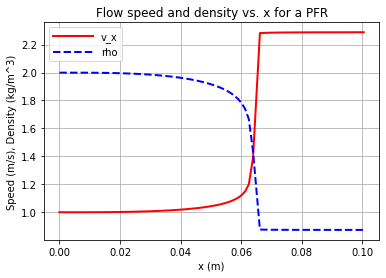

In [7]:
# plot flow speed and mass density as functions of x
fig, ax = plt.subplots()
ax.plot(xDevelopment.index, xDevelopment['v_x'], '-',  color='red',  label='v_x', lw=2)
ax.plot(xDevelopment.index, xDevelopment['rho'], '--', color='blue', label='rho', lw=2)
ax.set(xlabel='x (m)',
       ylabel='Speed (m/s), Density (kg/m^3)',
       title ='Flow speed and density vs. x for a PFR')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("vx-rho_vs_x_PFR.pdf")

The density decreases as the temperature increases, at constant pressure. The flow must speed up as the density decreases to maintain the constant mass flow rate. The product of flow speed and density is a constant for all $x$.

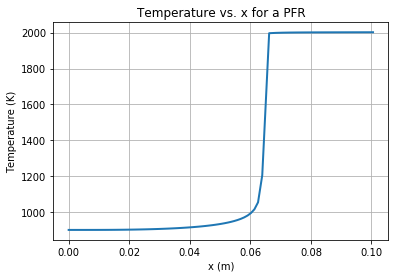

In [8]:
# plot temperature as a function of x
fig, ax = plt.subplots()
ax.plot(xDevelopment.index, xDevelopment['temperature'], '-', label='T', lw=2)
ax.set(xlabel='x (m)',
       ylabel='Temperature (K)',
       title ='Temperature vs. x for a PFR')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_x_PFR.pdf")

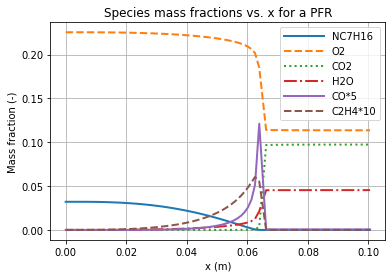

In [9]:
# plot major species, plus CO and C2H4, as a function of x
fig, ax = plt.subplots()
ax.plot(xDevelopment.index, xDevelopment['NC7H16'],   '-',  label='NC7H16',  lw=2)
ax.plot(xDevelopment.index, xDevelopment['O2'],       '--', label='O2',      lw=2)
ax.plot(xDevelopment.index, xDevelopment['CO2'],      ':',  label='CO2',     lw=2)
ax.plot(xDevelopment.index, xDevelopment['H2O'],      '-.', label='H2O',     lw=2)
ax.plot(xDevelopment.index, xDevelopment['CO']*5.,    '-',  label='CO*5',    lw=2)
ax.plot(xDevelopment.index, xDevelopment['C2H4']*10., '--', label='C2H4*10', lw=2)
ax.set(xlabel='x (m)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. x for a PFR')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Ymajor_vs_x_PFR.pdf")

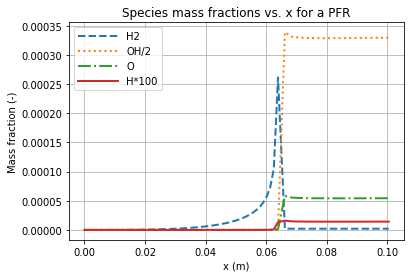

In [10]:
# plot some minor species as a function of x
fig, ax = plt.subplots()
ax.plot(xDevelopment.index, xDevelopment['H2'],     '--', label='H2',    lw=2)
ax.plot(xDevelopment.index, xDevelopment['OH']/2.,  ':',  label='OH/2',  lw=2)
ax.plot(xDevelopment.index, xDevelopment['O'],      '-.', label='O',     lw=2)
ax.plot(xDevelopment.index, xDevelopment['H']*100., '-',  label='H*100', lw=2)
ax.set(xlabel='x (m)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. x for a PFR')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Yminor_vs_x_PFR.pdf")

The temperature increases slowly at first, then more rapidly as the system approaches "ignition". The evolution of temperature with distance $x$ in a constant-pressure adiabatic PFR is similar to the evolution of temperature with time $t$ in a fixed-mass constant-pressure adiabatic reactor. The same is true for species mass fractions. The relationship between $x$ and $t$ is not linear, because the flow speed increases with increasing $x$.